##Analyzing the NYC subway dataset | Intro of Data Science
- Author:  Chi-Yuan Cheng (cyuancheng AT gmail DOT com) 
- Last updated: Feb 17th  2015

###Introduction

The goal of this project was to understand NYC Subway riding patterns using Python and its libraries including Pandas, matplotlib, and ggplot. Particulary, we will look at if more people ride the subway when it is raining versus when it is not raining. This project involved Data Wrangling, EDA, Machine Learning, and Data Visualization.

The key messages gained from this project are:

1. There are more people entering NYC Subway in rainy days than that in non-rainy days.
2. The hourly entries during the weekend are less busy than in the weekdays. 
3. The most busy hours on the weekend begin at 12pm and it reaches to its maximul level in the late afternoon (4pm-8pm). In contrast, the most busy hours in the weekdays are at 12pm and 8pm.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
%matplotlib inline 
from ggplot import *
from pylab import *
import datetime
import scipy.stats

The NYC subway and weather data during May 2011 was provided by Udacity. The original dataset can be found here:

* [NYC subway data](http://web.mta.info/developers/data/nyct/turnstile/turnstile_110507.txt)

* [NYC weather data](https://www.dropbox.com/s/7sf0yqc9ykpq3w8/weather_underground.csv)

Let's read data using pandas and show an overview of our data.

In [9]:
df = pd.read_csv('data/turnstile_weather_v2.csv')
df.head()

,UNIT,DATEn,TIMEn,ENTRIESn,EXITSn,ENTRIESn_hourly,EXITSn_hourly,datetime,hour,day_week,...,pressurei,rain,tempi,wspdi,meanprecipi,meanpressurei,meantempi,meanwspdi,weather_lat,weather_lon
0,R003,05-01-11,00:00:00,4388333,2911002,0,0,2011-05-01 00:00:00,0,6,...,30.22,0,55.9,3.5,0,30.258,55.98,7.86,40.700348,-73.887177
1,R003,05-01-11,04:00:00,4388333,2911002,0,0,2011-05-01 04:00:00,4,6,...,30.25,0,52.0,3.5,0,30.258,55.98,7.86,40.700348,-73.887177
2,R003,05-01-11,12:00:00,4388333,2911002,0,0,2011-05-01 12:00:00,12,6,...,30.28,0,62.1,6.9,0,30.258,55.98,7.86,40.700348,-73.887177
3,R003,05-01-11,16:00:00,4388333,2911002,0,0,2011-05-01 16:00:00,16,6,...,30.26,0,57.9,15.0,0,30.258,55.98,7.86,40.700348,-73.887177
4,R003,05-01-11,20:00:00,4388333,2911002,0,0,2011-05-01 20:00:00,20,6,...,30.28,0,52.0,10.4,0,30.258,55.98,7.86,40.700348,-73.887177


The dataset contains following properties:

NYC subway data

Property | Description
--- | ----
`UNIT` | Remote unit that collects turnstile information.
`DATEn` | Date in “mm-dd-yy” format
`TIMEn` | Time in “hh:mm:ss” format
`ENTRIESn` | Raw reading of cummulative turnstile entries from the remote unit. 
`EXITSn` | Raw reading of cummulative turnstile exits from the remote unit 
`ENTRIESn_hourly` | Difference in ENTRIES from the previous REGULAR reading
`EXITSn_hourly` | Difference in EXITS from the previous REGULAR reading
`datetime` | Date and time in “yyyy:mm:dd hh:mm:ss” forma
`hour` | Hour of the timestamp from TIMEn
`day_week` | Integer (0-6 Mon-Sun) corresponding to the day of the week
`weekday` | Indicator (0 or 1) if the date is a weekday (Mon-Fri)
￼￼￼￼￼`station` | Subway station corresponding to the remote unit
`latitude` | Latitude of the subway station corresponding to the remote unit
`longitude` | Longitude of the subway station corresponding to the remote unit

Weather data

Property | Description
--- | ----
`conds` | Categorical variable of the weather conditions (Clear, Cloudy etc.) for the time and location
`fog` | Indicator (0 or 1) if there was fog at the time and location
`precipi` | Precipitation in inches at the time and location 
`pressurei` | Barometric pressure in inches Hg at the time and location
`rain` | Indicator (0 or 1) if rain occurred within the calendar day at the location.
`tempi` | Temperature in °F at the time and location
`wspdi` | Wind speed in mph at the time and location
`meanprecipi` | Daily average of precipi for the location
`meanpressurei` | Daily average of pressurei for the location
`meantempi` | Daily average of tempi for the location
`meanwspdi` | Daily average of wspdi for the location
`weather_lat` | Latitude of the weather station the weather data is from
`weather_lon` | Longitude of the weather station the weather data is from


###Section 1. Statistical Test
*1.1 Which statistical test did you use to analyse the NYC subway data? Did you use a one-tail or a two-tail p value? What is the null hypothesis? What is your p-critical value?*

>I used two-tailed statistical test. **The null hypothesis is that the datasets of ridership in rainy and non-rainy days are identical.** The p-critical value is 0.025 for the probability distribution of a 95% confidence level.

*1.2 Why is this statistical test applicable to the dataset? In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.*

>I used the histograms to analyze the number of turnstile entries per hour (ENTRIESn_hourly) in rainy vs. non-rainy days (Fig.1). The result shows it is not a normal distribution, so doing a Welch’s T-Test would not work well. The Mann-Whitney U-test is a non-parametric test, and does not assume any particular distribution. Therefore, the Mann-Whitney U-test is used to analysis the hourly entries data in the NYC subway dataset. 

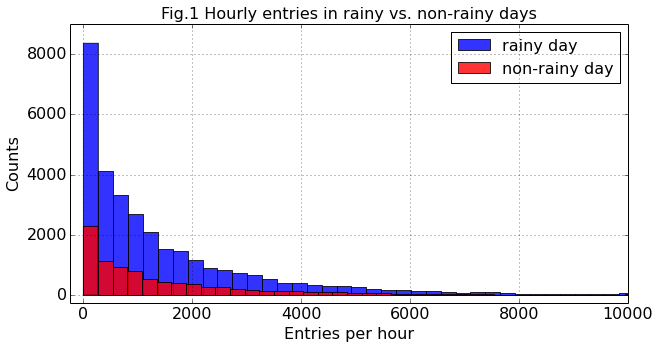

In [10]:
fig, ax = plt.subplots(figsize=(10, 5)) 

df.ENTRIESn_hourly[df.rain==0].hist(alpha=0.8,bins=120, facecolor='blue') 
df.ENTRIESn_hourly[df.rain==1].hist(alpha=0.8,bins=120, facecolor='red')

plt.title('Fig.1 Hourly entries in rainy vs. non-rainy days', size=16)
plt.ylabel('Counts', size=16)
plt.xlabel('Entries per hour',size=16)
plt.axis((-250, 10000, -250, 9000))
plt.legend(['rainy day','non-rainy day'], fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.show()

*1.3 What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the means for each of the two samples under test.*

>Since the p-value returned from the U-test is < 0.025, we can reject the null hypothesis and imply the number of hourly entries is statistically different between rainy and non-rainy days.

In [11]:
# Mann Whitney U-test
U,p = scipy.stats.mannwhitneyu(df.ENTRIESn_hourly[df.rain==1], df.ENTRIESn_hourly[df.rain==0]) 
print 'U-value = %s' %(U)
print 'p-value = %.10f' %(p)

U-value = 153635120.5
p-value = 0.0000027411


*1.4 What is the significance and interpretation of these results?*

>**Besed on the U-test, we can conclude that the ridership is significantly different in rainy days vs. in non-rainy days.** We can further do statistical analysis on the datasets of hourly entries in rainy and non-rainy day. The result is summarized in the table below. 

In [30]:
df_rain = df[["rain", "ENTRIESn_hourly"]]
df_rain["category "] = np.where(df_rain["rain"] == 1, "raining", "no raining")
df_rain.groupby("category ").describe()

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


ENTRIESn_hourly   rain
category                                
no raining count     33064.000000  33064
           mean       1845.539439      0
           std        2878.770848      0
           min           0.000000      0
           25%         269.000000      0
           50%         893.000000      0
           75%        2197.000000      0
           max       32814.000000      0
raining    count      9585.000000   9585
           mean       2028.196035      1
           std        3189.433373      0
           min           0.000000      1
           25%         295.000000      1
           50%         939.000000      1
           75%        2424.000000      1
           max       32289.000000      1

>Because the hourly entries data is not normal distributed, we will need to use the *median* instead of mean to compare the data between rainy and non-rainy days.

In [14]:
print "The median of hourly entries in raining days =%s" %(df_rain.ENTRIESn_hourly[df_rain["rain"] == 1].median())
print "The median of hourly entries in non-raining days = %s" %(df_rain.ENTRIESn_hourly[df_rain["rain"] == 0].median())

The median of hourly entries in raining days =939.0
The median of hourly entries in non-raining days = 893.0


>Based on the median values, we can conclude that **the number of hourly entries in rainy days is greater than that in non-rainy days.**

###Section 2. Linear Regression
In the following, we will use machine learning to predict the ridership of NYC subway dataset.

*2.1 What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model?*

>I used the **Gradient Descent (GD)** model to do the linear regression on the NYC subway dataset. This model gives a good linear fit between the features and the predicted values for the hourly entries (ENTRIESn_hourly) in the NYC subway dataset. 


*2.2 What features (input variables) did you use in your model? Did you use any dummy variables as part of your features?*

>The features I uses were: *rain*, *hour*, *weekday*, *precipi*, and *meantempi*. The dummy variable I used is *unit* for the GD method.

*2.3 Why did you select these features in your model? We are looking for specific reasons that lead you to believe that the selected features will contribute to the predictive power of your model.*

>By playing with the features as a training dateset to the model, I found that these features gives higher $R^2$ value. For examle, prior to adding 'hour' and 'weekday' features, the $R^2$ value is barely above 0.4. Adding the 'hour' and 'weekday' features significantly increases the $R^2$ value to 0.496. I also played around with other parameters, but none of them were sensitive to the $R^2$ value. Another way to know which feature has an impact to the prediction is to determine their theta values ($\theta$) in the model. The theta value can point out which features add greater impact to the predicted value and the learning accuracy ($R^2$ value). 

>####Machine Learning


>Here, I summarize the linear regression using the GD model. We will examine the relationship between the cost function $J(\theta)$, the convergence of gradient descent, and the learning rate $\alpha$.

>We will use the NYC subway/weather data as a training set, where the output $y^{(i)}$ **(values)** is the entries per hour (ENTRIESn_hourly) and the inputs $x^{(i)}$ **(features)** are the subway ridership and weather variables.

>We first normalize the inputs $x^{(i)}$ by their standard deviations and set their means to zero.

In [16]:
def normalize_features(array):
    mu = array.mean()
    sigma = array.std()
    array_normalized = (array - mu)/sigma
    return array_normalized, mu, sigma

>Then, we introduce the gradient descent.
The hypothesis function is

>$$
\begin{aligned}
h_{\theta}(x) =\theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_n x_n  &= \sum_{i=0}^n \theta_i x_i, \nonumber
\end{aligned}	 
$$

>and the batch gradient descent update rule is

>$
\theta_j = \theta_j - \frac{\alpha}{m} \displaystyle \sum_{i=1}^{m} \left(h_{\theta}(x^{(i)}) - y^{(i)} \right ) x^{(i)}
$

>A good learning rate $\alpha$ is typilcally in the range of 
$
0.001 \leq \alpha \leq 10 \nonumber
$

>We can make an initial selection, running gradient descent and observing the cost function, and adjusting the learning rate accordingly. The cost function is defined as
>
$
\begin{aligned}
J(\theta) &= \frac{1}{2m} \displaystyle \sum_{i=1}^{m} \left( \textrm{predictions} - \textrm{actuals} \right) ^ 2 = \frac{1}{2m} \displaystyle \sum_{i=1}^{m} \left(h_{\theta}(x^{(i)}) - y^{(i)} \right) ^ 2
\end{aligned}
$

>We can now calculate $J(\theta)$ using the $\theta$ of the current stage of gradient descent. After stepping through many stages, we will see how $J(\theta)$ changes as the iterations advance.

>The cost function and gradient descent are defined as follows:

In [17]:
def compute_cost(features, values, theta):
    m = len(values)
    sum_of_square_errors = np.square(np.dot(features, theta) - values).sum()
    cost = sum_of_square_errors / (2*m)
    return cost

def gradient_descent(features, values, theta, alpha, num_iterations):
    m = len(values)
    cost_history = []
    for i in range(0,num_iterations):
        theta = theta - (alpha/m)*np.dot((np.dot(features,theta)-values),features)
        cost = compute_cost(features, values, theta)
        cost_history.append(cost)
    return theta, pd.Series(cost_history)

>Next, we introduce the prediction functions for the GD model. We set $\alpha$=0.1 with 150 steps.

In [18]:
#prediction function for GD
def predictions_GD(features, values, alpha, num_iterations):
    m = len(values)
    theta = np.zeros(features.shape[1])
    theta, cost_history = gradient_descent(features, values, theta, alpha, num_iterations)
    predictions_GD = features.dot(theta) # hypothesis function
    predictions_GD[predictions_GD<0] = 0 # Predictions should be greater than 0
    return theta, pd.Series(predictions_GD) 

dummy_units = pd.get_dummies(df['UNIT'], prefix='unit') # dummy values for the feature

features = df[['rain','hour','weekday','precipi','meantempi']].join(dummy_units)
features, mu, sigma = normalize_features(features) # normalize feature values
features = np.array(features)
features = np.insert(features, 0, 1, axis=1) # add initial value (x)
values =  df['ENTRIESn_hourly'] 
theta_GD, pred_GD = predictions_GD(features=np.array(features),
                   values=values,
                   alpha=0.1,
                   num_iterations=150)

In [28]:
#make a new dataframe included predictions
predict_df = df[["UNIT", "datetime", "ENTRIESn_hourly"]].join(pd.Series(pred_GD, name="pred_GD"))
predict_df.head(6)

,UNIT,datetime,ENTRIESn_hourly,pred_GD
0,R003,2011-05-01 00:00:00,0,0.000000
1,R003,2011-05-01 04:00:00,0,0.000000
2,R003,2011-05-01 12:00:00,0,0.000000
3,R003,2011-05-01 16:00:00,0,320.181902
4,R003,2011-05-01 20:00:00,0,809.576162
5,R003,2011-05-02 00:00:00,15,0.000000


*2.4 What are the coefficients (or weights) of the non-dummy features in your linear regression model?*
> The coefficients ($\theta$) of the non-dummy features in the GD model are listed below.

>feature | $\theta$ (GD) 
--- | ---- 
`rain` | 1886.5897
`hour` | 12.1996
`weekday` | 848.9679
`precipi` | 446.6123
`meantempi` | -89.9421 

In [20]:
#print the first four values in theta_GD
theta_GD[:5]

array([ 1886.58969696,    12.19957997,   848.96790035,   446.61234022,
         -89.94213529])

*2.5 What is your model’s R2 (coefficients of determination) value?*

>To evaluate how good these predictions are, we introduce the **coefficient of determination**, which measure the variability of the model. It varies from 0 to 1 and a larger value indicates a better fit.

>$
\begin{aligned}
R^2 &= 1 - \frac{ \displaystyle \sum_{i=1}^{m} \left( y_i - f_i \right)^2 }{ \displaystyle \sum_{i=1}^{m} \left( y_i - \bar{y}_i \right)^2 }
\end{aligned}
$

In [29]:
def compute_r_squared(data, predictions):
    num = ((data - predictions)**2).sum()
    den = ((data - data.mean())**2).sum()
    r_squared = 1 - (num / den)
    return r_squared

print "R^2 for the GD model is %.3f." % (compute_r_squared(df["ENTRIESn_hourly"], pred_GD))

R^2 for the GD model is 0.496.


*2.6 What does this R2 value mean for the goodness of fit for your regression model? Do you think this linear model to predict ridership is appropriate for this dataset, given this R2 value?*

>The $R^2$ value is 0.496 for the GD model, which means that the model has explained 49.6% of the original variability and are left with 50.4% of the residual variability. Based on the high $R^2$ value, I think the GD model is appropriate to predict the ridership for the NYC subway dataset. 

>We can also plot the residuals between actual and predicted values to determine how good a statistical model is. A residual plot of a good model will be distributed as a normal distribution with a mean of 0 and some finite variances, as shown in Fig.2.

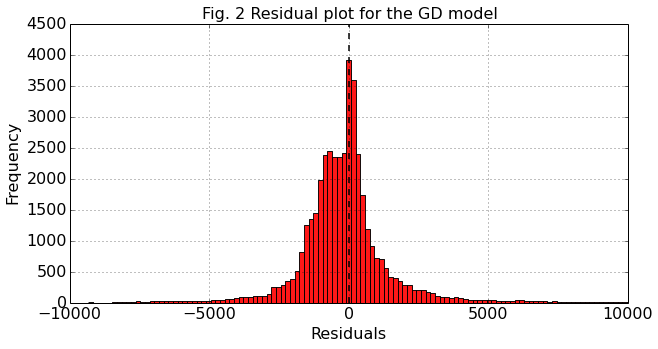

In [22]:
fig, ax = plt.subplots(figsize=(10, 5)) 

yaxis_GD = df["ENTRIESn_hourly"] - pred_GD
yaxis_GD.hist(bins=200, alpha=0.9, color='red')

plt.plot([0, 0], [0, 10000], 'k--', lw=1.5) # draw vertical line 
plt.title("Fig. 2 Residual plot for the GD model", size=16)
plt.xlabel("Residuals", size=16)
plt.ylabel("Frequency", size=16)
plt.axis((-10000, 10000, 0, 4500))
ax.tick_params(axis='both', which='major', labelsize=16)

###Section 3. Visualization

*3.1 One visualization should contain two histograms: one of  ENTRIESn_hourly for rainy days and one of ENTRIESn_hourly for non-rainy days.*
>See Fig.1.

*3.2 One visualization can be more freeform. Some suggestions are: Ridership by time-of-day, Ridership by day-of-week*
> (1) Ridership by days

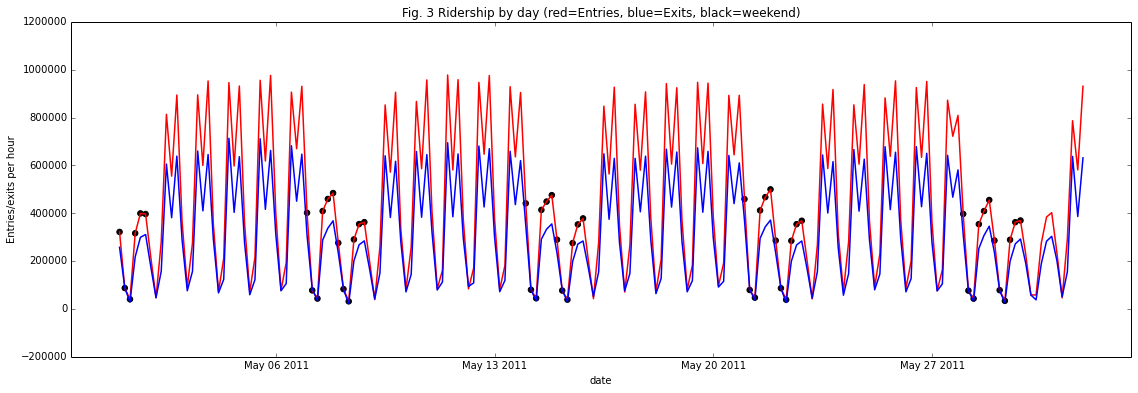

<ggplot: (280296757)>

In [23]:
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M:%S") # convert string to pandas datetime

DatetimeEntriesExit = df[['datetime', 'ENTRIESn_hourly', 'EXITSn_hourly']].groupby('datetime', as_index=False).sum()
DatetimeEntries_weekend = df[['datetime', 'weekday','ENTRIESn_hourly']].groupby('datetime', as_index=False).sum()
ix_weekend = DatetimeEntries_weekend.datetime[DatetimeEntries_weekend ['weekday']==0].index.tolist() # find index on weekend
datetime_weekend = DatetimeEntries_weekend.datetime[DatetimeEntries_weekend ['weekday']==0] # find datetime on weekend
Entries_weekend = DatetimeEntries_weekend.iloc[ix_weekend]['ENTRIESn_hourly'] # find entries on weekend

ggplot(aes(x='datetime'), data = DatetimeEntriesExit) \
    + geom_line(aes(y='ENTRIESn_hourly'), color='red', size=1.5) \
    + geom_line(aes(y='EXITSn_hourly'), color='blue', size=1.5)\
    + geom_point(aes(x='datetime_weekend', y='Entries_weekend'), data = DatetimeEntries_weekend, color='black', size = 30)\
    + ggtitle('Fig. 3 Ridership by day (red=Entries, blue=Exits, black=weekend)') \
    + ylab('Entries/exits per hour')+xlab('date') + theme_matplotlib(rc={"figure.figsize": "19, 6"}) 


>We can compare the numbers of hourly entries (red) and hourly exits (blue) aross all stations during May 2011 in Fig. 3. The interesting findings were summarized below:
* There are several spikes in both entries and exits in particular day/times. I used the black points to label the entries data on the weekend. The data shows the hourly entries during the weekend are less busy, compared to the entries in the weekdays. One outlier is on Monday, May 30, which has less busy entries/exits. But it is Memorial day holiday.
* It seems the entries/exits data has a specific pattern during a day in the weekdays. The patterns in the weekdays and on the weekend are quite differnet. We will see how the day of the week and the hour of the day affect the number of hourly entries/exits in next two figures.
* The total number of hourly entries and exits are very different. It could be because people somehow bypass turntiles to exit. For example, the riders may use the emergency exits in major stations, such as 42nd St-Times Square.

In [24]:
print 'Total number of hourly entries = %s' %(df.ENTRIESn_hourly.sum()) 
print 'Total number of hourly exits = %s' %(df.EXITSn_hourly.sum())

Total number of hourly entries = 80461175.0
Total number of hourly exits = 58066096.0


>(2) Ridership by day-of-week

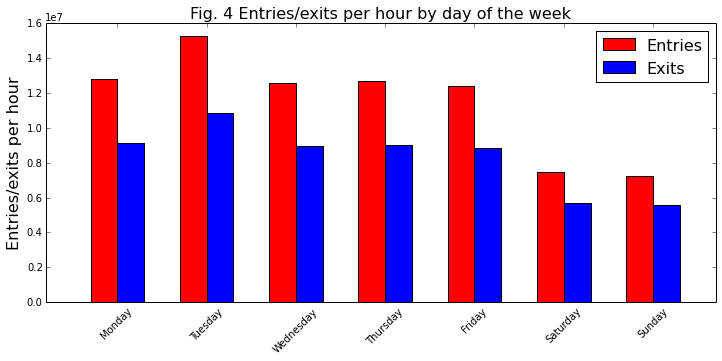

In [25]:
EntriesExitDay = df[['day_week','ENTRIESn_hourly', 'EXITSn_hourly']].groupby('day_week', as_index=False).sum()

fig, ax = plt.subplots(figsize=(12, 5))
width=0.3
rects1 = ax.bar(EntriesExitDay.day_week, EntriesExitDay.ENTRIESn_hourly, width, color='red')
rects2 = ax.bar(EntriesExitDay.day_week+width, EntriesExitDay.EXITSn_hourly, width, color='blue')

plt.xlim(-0.5,7)
plt.ylabel('Entries/exits per hour', size=16)
plt.title('Fig. 4 Entries/exits per hour by day of the week',size=16)
ax.set_xticks(EntriesExitDay.day_week+width)
ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday",],rotation=45)
ax.legend(["Entries", "Exits"], fontsize=16)
plt.show()

>If we sum up the number of entries and exits by day of the week across all stations, we found that Saturday and Sunday are the least busy days. Tuesday is the most busy day.

>(3) Ridership by time-of-day

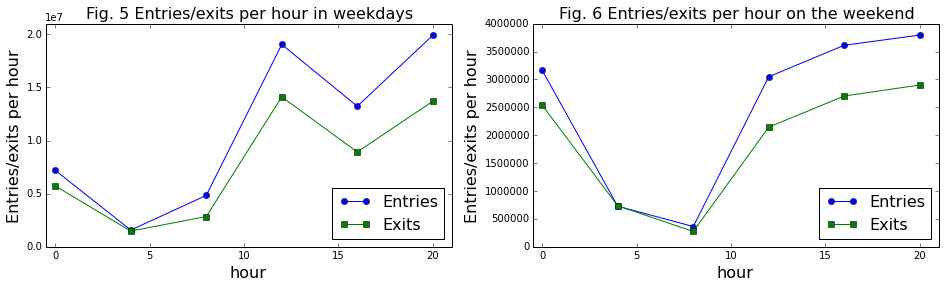

In [26]:
# weekend data
ix_weekend = df.hour[df['weekday']==0].index.tolist() # find index on weekend
hour_weekend  = df.hour[df['weekday']==0] # find datetime on weekend
Entries_weekend = df.iloc[ix_weekend]['ENTRIESn_hourly'] # find entries on weekend
Exits_weekend = df.iloc[ix_weekend]['EXITSn_hourly'] # find entries on weekend
A=pd.Series(hour_weekend, name='hour_weekend')
B=pd.Series(Entries_weekend, name='Entries_weekend')
C=pd.Series(Exits_weekend, name ='Exits_weekend')
data_weekend = pd.concat([A,B,C],axis=1)
data1_weekend=pd.DataFrame(data_weekend).groupby("hour_weekend", as_index=False).sum()

#weekday data
ix_weekday = df.hour[df['weekday']!=0].index.tolist() # find index on weekend
hour_weekday  = df.hour[df['weekday']!=0] # find datetime on weekday
Entries_weekday = df.iloc[ix_weekday]['ENTRIESn_hourly'] # find entries on weekday
Exits_weekday = df.iloc[ix_weekday]['EXITSn_hourly'] # find entries on weekday
D=pd.Series(hour_weekday , name='hour_weekday')
E=pd.Series(Entries_weekday , name='Entries_weekday')
F=pd.Series(Exits_weekday , name ='Exits_weekday')
data_weekday = pd.concat([D,E,F],axis=1)
data1_weekday=pd.DataFrame(data_weekday).groupby("hour_weekday", as_index=False).sum()

fig, ax = plt.subplots(figsize=(16, 4)) 
plt.subplot(121)
plt.plot(data1_weekday.hour_weekday, data1_weekday.Entries_weekday,'-o',\
         data1_weekday.hour_weekday, data1_weekday.Exits_weekday,'-s')
plt.xlabel("hour", size=16)
plt.ylabel("Entries/exits per hour",size=16)
plt.legend(["Entries", "Exits"],fontsize=16, loc=4)
plt.title("Fig. 5 Entries/exits per hour in weekdays",size=16)
plt.axis((-0.5, 21, 0, 2.1e7))
ax.tick_params(axis='both', which='major', labelsize=16)

plt.subplot(122)
plt.plot(data1_weekend.hour_weekend, data1_weekend.Entries_weekend,'-o',\
         data1_weekend.hour_weekend, data1_weekend.Exits_weekend,'-s')
plt.xlabel("hour", size=16)
plt.ylabel("Entries/exits per hour",size=16)
plt.legend(["Entries", "Exits"],fontsize=16, loc=4)
plt.title("Fig. 6 Entries/exits per hour on the weekend",size=16)
plt.axis((-0.5, 21, 0, 0.4e7))
ax.tick_params(axis='both', which='major', labelsize=16)

>As mentioned previously, the hourly entries/exits data has a different pattern between the weekdays and the weekend. Here, I plot the total hourly entries and exits grouped by hour in the weekdays (Fig. 5) versus on the weekend (Fig. 6) to see which hours are more busy than others. The data suggest that the most busy hours are 12pm and 8pm in the weekdays, whereas the busy hours on the weekend begin at 12pm and it reaches to its maximul level in the afternoon (4pm-8pm). The busy hour on the weekend drops from 12am to 8am. Overall, the total number of entries on the weekend is about a factor of 4.5 less than in the weekdays.

In [27]:
print 'Total number of hourly entries in the weekdays = %.0f' %(data1_weekday.Entries_weekday.sum()) 
print 'Total number of hourly entries on the weekend = %.0f' %(data1_weekend.Entries_weekend.sum())
print 'the total number of entries on the weekend is about a factor of %.1f less than in the weekdays.\
'%(data1_weekday.Entries_weekday.sum()/data1_weekend.Entries_weekend.sum())

Total number of hourly entries in the weekdays = 65755562
Total number of hourly entries on the weekend = 14705613
the total number of entries on the weekend is about a factor of 4.5 less than in the weekdays.


###Section 4. Conclusion

*4.1 From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining?*
>Based on the data analysis, we can conclude that **more people ride the NYC subway when it is raining**. 

*4.2 What analyses lead you to this conclusion? You should use results from both your statistical tests and your linear regression to support your analysis.*
>There are about 46 more people ride the NYC system in a rainy day, compared to a non-rainy day. This conclusion is made based on the Mann Whitney U-test and the median values of the hourly entries in the rainy day vs. non-rainy day. Additionally, in the GD model, the feature of rain has a greater theta ($\theta$) value of 1886.6. These findings suggest that rain has a greater impacts on the hourly entries of NYC subway systems.


###Section 5. Reflection

5.1 Please discuss potential shortcomings of the methods of your analysis, including:
		Dataset,
		Linear regression model,
		Statistical test.
>Firstly, the possible shortcomings of the dataset is that the entries data only record every four hours, and the data were only recorded during May 2011. Secondly, the weather dataset was recorded by day. To make the data more percise, the weather data should be recorded by hour and by location. Although the linear regression gives a good fit to our dataset, one could make a complex model or feed in more features or more month logged data to improve the accuracy of the prediction.

###Reference

* [Mann-Whitney U-Test](https://explorable.com/mann-whitney-u-test)
* [R-square](http://www.statsoft.com/Textbook/Multiple-Regression#cresidual)
* Python for Data Analysis, by Wes McKinney, O'Reilly Media, 2012. 